In [1]:
import numpy as np
import pandas as pd
import altair as alt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression, load_boston
from sklearn.model_selection import train_test_split, cross_validate, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
# from sklearn.model_selection import check_cv
from sklearn.base import clone
import duplicate as dp
from functools import partial
import matplotlib.pyplot as plt



In [2]:
# get bootstrap.py from parent directory
%cd ..
import bootstrap as bs
import reed as reed
%cd -

/Users/jack/Documents/GitHub/re-education
/Users/jack/Documents/GitHub/re-education/duplication


In [3]:
# X, y = load_boston(return_X_y=True)
X, y = make_regression(n_samples=5_000,n_features=10, n_informative=7, noise=1, random_state=0)#,effective_rank=3, )

feature_names = [f'X_{i}' for i in range(X.shape[1])]
data = pd.DataFrame(data=X, columns=feature_names)
data['y'] = y
# data.info()

In [4]:
n_duplicates = 4
n_splits = 5
base_groups = np.arange(y.size)
# X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.90, shuffle=True)
X_dup, y_dup, groups_dup = dp.simple_duplicate(X_train, y_train, n_duplicates, shuffle=True)

scoring = {
    "MSE": make_scorer(metrics.mean_squared_error),
    "R2": make_scorer(metrics.r2_score),
}


Found 100 representative points (based on first 4500 of 4500 test samples)


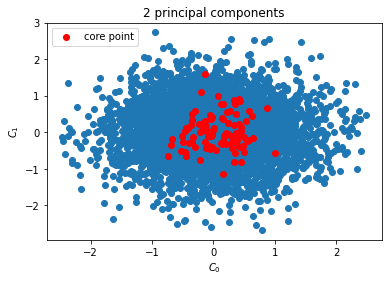

In [5]:


# take an arbitrary point in the test set; let's see how its performance changes:
# get represetative point/s from sub-sample if X_test/y_test is huge
# (assumes that test set is shuffled)
n_test_samples = X_test.shape[0]
subset_indices = range(10_000) if n_test_samples > 10_000 else range(n_test_samples)
core_indices = dp.find_representative_point_indices(X_test[subset_indices], y_test[subset_indices], max_num_points=-1, plot=True)#[0]
print(f"Found {len(core_indices)} representative points (based on first {len(subset_indices)} of {X_test.shape[0]} test samples)")


## Scaling with number of duplicates

Here I'm trying to get a sense of how things scale with the number of duplicates. In particular:
- the boostrapped variance of a point estimate

In [6]:
def param_extractor(estimator):
    # extract estimator parameters; this can be used for all sklearn estimators
    return estimator.get_params()

grad_boost = GridSearchCV(
    # LinearRegression(),
    GradientBoostingRegressor(random_state=0),
    # reed.StatsmodelsOLS(),
    param_grid={}, 
    cv=GroupKFold(n_splits=n_splits)
)

models = {
    "linear": {
        "model": LinearRegression(),
        "bootstrap_params": {"groups": None, "parameter_extractor": param_extractor}
    },
    "lasso" : {
        "model": Lasso(), 
        "bootstrap_params": {"groups": None, "parameter_extractor": param_extractor}
    },
    
    "gb" : {
        "model": grad_boost,
        "bootstrap_params": {"groups": groups_dup, "paramater_extractor": param_extractor}
    }
}


n_duplicates = [1,2,4]
use_sample_weight = [False, True]

param_grid = dict(
    n_duplicates=n_duplicates,
    use_sample_weight=use_sample_weight
)



In [7]:

results = dp.grid_with_bootstrap(
    X_train, y_train, X_test, y_test,
    models=models, 
    n_duplicates=n_duplicates, 
    use_sample_weight=use_sample_weight
    )


linear
------------------
{'n_duplicates': 1, 'use_sample_weight': False}
{'n_duplicates': 1, 'use_sample_weight': True}
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups
No groups

TypeError: bootstrap() got an unexpected keyword argument 'param_extractor'

In [ ]:



def inspect_point(y_test, results, index):
    """
    Plot information about models' predictions for a particular point at
    y_test[index]
    
    """
    # prepare data for plotting
    result_chart = pd.DataFrame(results)
    result_chart["point_pred"] = [[model_pred[index] for model_pred in bs_preds] for bs_preds in result_chart["bs_y_preds"]]
    # print(result_chart["point_pred"])

    result_chart["point_mean"] = [np.mean(point_pred) for point_pred in result_chart["point_pred"]]
    result_chart["point_mean_shifted"] = result_chart["point_mean"] - y_test[index]
    result_chart["point_std"] = [np.std(point_pred) for point_pred in result_chart["point_pred"]]
   
    n_equals_1 = result_chart[result_chart["n_duplicates"] == 1]
    

    # create new column of normalised standard deviations; scaled by stdev of the model at n=1
    result_chart["point_std_normalised"] = result_chart["point_std"]
    # iterate over the rows with unduplicated data and update the matching rows' stdevs
    for i, undup_row in n_equals_1.iterrows():
        std_1 = undup_row["point_std"]
        id_columns = ["model_name", "use_sample_weight"]
        # divide the matching stdevs by the value at n=1
        matching_rows = np.logical_and.reduce([(result_chart[c] == undup_row[c]) for c in id_columns])
        
        result_chart["point_std_normalised"][matching_rows] /= std_1


    # most objects are lists; unnecessary/un-serialisable
    result_chart = result_chart.select_dtypes(exclude="object")
    # but we do want to access the name
    result_chart["model_name"] = results["model_name"]
    
    base = alt.Chart(result_chart).transform_calculate(
        point_low = "datum.point_mean-datum.point_std",
        point_high = "datum.point_mean+datum.point_std",
        point_low_shifted = "datum.point_mean_shifted-datum.point_std",
        point_high_shifted = "datum.point_mean_shifted+datum.point_std"
    )

    std_chart = base.mark_line().encode(
        x="n_duplicates",
        y="point_std_normalised",
        color="model_name",
        # shape="use_sample_weight",
        strokeDash="use_sample_weight"
    )

    shifted_mean_chart = base.mark_line().encode(
        x="n_duplicates",
        y="point_mean_shifted",
        color="model_name",
        # shape="use_sample_weight",
        strokeDash="use_sample_weight" 
    )

    shifted_stdev_chart = base.mark_line().encode(
        x="n_duplicates",
        y="point_low_shifted:Q",
        y2="point_high_shifted:Q",
        color="model_name",
        # shape="use_sample_weight",
        strokeDash="use_sample_weight" 
    )

    general_mean_chart = base.mark_point().encode(
        x="n_duplicates",
        y="point_mean",
        color="model_name",
        # shape="use_sample_weight",
        strokeDash="use_sample_weight" 
    )
    general_true = alt.Chart(
        pd.DataFrame({'y_true': [y_test[index]]})
        ).mark_rule().encode(
            y='y_true'
        )

    general_error_chart = base.mark_errorbar().encode(
        x="n_duplicates",
        y="point_low:Q",
        y2="point_high:Q",
        color="model_name",
        # shape="use_sample_weight",
        strokeDash="use_sample_weight" 
    )
    return std_chart | (shifted_mean_chart + shifted_stdev_chart) | (general_mean_chart + general_true + general_error_chart)


def inspect_bootstrap(y_test, results):
    # Add bootstrap statistics to results
    # and visualise

    results["bs_mse"] = [ 
        [ metrics.mean_squared_error(y_test, model_y_pred) for model_y_pred in y_preds ] 
        for y_preds in results["bs_y_preds"] 
    ]

    results["bs_mse_mean"] =[ np.mean(bs_mse) for bs_mse in results["bs_mse"] ] 
    results["bs_mse_std"] =[ np.std(bs_mse) for bs_mse in results["bs_mse"] ] 
    results_df = pd.DataFrame(results)
    
    # most objects are lists; unnecessary/un-serialisable
    results_chart = results_df.select_dtypes(exclude="object")
    # but we do want to access the name
    results_chart["model_name"] = results["model_name"]

    base = alt.Chart(results_chart).transform_calculate(
        mse_low = "datum.bs_mse_mean-datum.bs_mse_std",
        mse_high = "datum.bs_mse_mean+datum.bs_mse_std"
    )

    points = base.mark_point().encode(
        x = "n_duplicates",
        y = "bs_mse_mean",
        color = "model_name:N",
        shape = "use_sample_weight"
    )
    errors = base.mark_errorbar().encode(
        x = "n_duplicates",
        y = "mse_low:Q",
        y2= "mse_high:Q",
        color = "model_name:N",
        shape = "use_sample_weight"
    )



    return errors + points


In [ ]:
# results_df = pd.DataFrame(results)
# results_df.select_dtypes(exclude=object)

# results_df.info()


In [ ]:
inspect_bootstrap(
    y_test=y_test,
    results = results
)

inspect_point(y_test, results, 0)
# for i in core_indices[:10]:
#     inspect_point(y_test, results, i)

/var/folders/st/bzr9mpf91hs5yw7v3tv1l7_w0000gn/T/ipykernel_48320/3454501602.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_chart["model_name"] = results["model_name"]
/var/folders/st/bzr9mpf91hs5yw7v3tv1l7_w0000gn/T/ipykernel_48320/3454501602.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_chart["point_std_normalised"][matching_rows] /= std_1


alt.HConcatChart(...)

# Visualise data

In [ ]:
chart = alt.Chart(data[:500]).mark_point().encode(
    x='X_0',
    y='y',
    color='X_1:Q'
).properties(
    width=200,
    height=200
)

# un-comment to view
chart

alt.Chart(...)

In [ ]:
correlations = data.corr().stack().reset_index().rename(columns={0: 'correlation', 'level_0': 'variable 0', 'level_1': 'variable 1'})
# print(correlations.head())
corr_mat = alt.Chart(correlations[:500]).mark_rect().encode(
    x='variable 0:N',
    y='variable 1:N',
    color='correlation:Q'
).properties(
    width=200,
    height=200
)

combined_fig = alt.concat(
chart,
corr_mat
).resolve_scale(
    color='independent'
)

# un-comment to view
combined_fig

alt.ConcatChart(...)